## script for data acquisition

#### Content:
- city boundaries of Graz
- street network of Graz and surrounding area within 1000m
- POIs in Graz and surrounding area withing 1000m: 
  public transport stations, supermarkets, green spaces, pharmacies, doctors
- population of Graz for the year 2020 (100x100m grid)
- buildings of Graz
- residential areas of Graz

#### Data sources:
- City Boundaries:
OpenStreetMap contributors (2025). OpenStreetMap database (city & District Boundaries). Retrieved December 22, 2025, from https://www.openstreetmap.org
- Street Network:
OpenStreetMap contributors (2025). OpenStreetMap database (Street Network). Retrieved December 23, 2025, from https://www.openstreetmap.org
- POIs:
OpenStreetMap contributors. (2025). OpenStreetMap database (POI). Retrieved December 25, 2025, from https://www.openstreetmap.org
- Population 2020 (100m grid):
Pesaresi, M., Schiavina, M., Politis, P., Freire, S., Krasnodębska, K., Uhl, J. H., Carioli, A., Corbane, C., Dijkstra, L., Florio, P., Friedrich, H. K., Gao, J., Leyk, S., Lu, L., Maffenini, L., Mari-Rivero, I., Melchiorri, M., Syrris, V., Van Den Hoek, J., & Kemper, T. (2023). GHS-POP R2023A — GHS population grid multitemporal (1975–2030). Dataset: GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20. European Commission, Joint Research Centre. https://doi.org/10.2905/2FF68A52-5B5B-4A22-8F40-C41DA8332CFE. Available under: https://human-settlement.emergency.copernicus.eu/download.php?ds=pop
- Buildings:
OpenStreetMap contributors (2025). OpenStreetMap database (Buildings). Retrieved December 26, 2025, from https://www.openstreetmap.org
- Residential Areas:
OpenStreetMap contributors (2025). OpenStreetMap database (Residential). Retrieved December 26, 2025, from https://www.openstreetmap.org

In [1]:
pip install osmnx rasterio

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask

Define file and output paths here:

In [2]:
# file path for GHS population grid
path_pop = r"C:\1_Daten\01_UniGraz\2025 WiSe\VU GIS Analysis Techniques 2\final_project\GIS2_Group3_FinalProject\data\GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R4_C20.tif"

# set output file path for preprocessed population grid for Graz
path_pop_graz = r"C:\1_Daten\01_UniGraz\2025 WiSe\VU GIS Analysis Techniques 2\final_project\GIS2_Group3_FinalProject\preprocessed\graz_population.tif"

### Data integration

##### Load city boundary of Graz

In [3]:
# define place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change CRS to EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

##### Load district boundaries of Graz

In [4]:
# get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# filter to get only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

##### Load street network of Graz and 1000m beyond

In [5]:
# buffer (1000m) boundary of Graz
buffered_poly_31256 = gdf_graz.geometry.iloc[0].buffer(1000)

# reproject buffer for osmnx (WGS84)
buffered_poly_wgs84 = (
    gpd.GeoSeries([buffered_poly_31256], crs="EPSG:31256")
    .to_crs("EPSG:4326")
    .iloc[0]
)

# load street network in buffered polygon, network_type = 'walk'
G = ox.graph_from_polygon(
    buffered_poly_wgs84,
    network_type="walk",
    simplify=True
)

# reproject to project crs
G = ox.project_graph(G, to_crs="EPSG:31256")

# convert street network graphs into two GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# remove list columns
def drop_list_columns(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    list_cols = [
        c for c in gdf.columns
        if c != "geometry" and gdf[c].apply(lambda x: isinstance(x, list)).any()
    ]
    return gdf.drop(columns=list_cols)

edges_clean = drop_list_columns(edges)
nodes_clean = drop_list_columns(nodes)

# save as GeoParquet
edges_clean.to_parquet("graz_street_network_edges.parquet", index=False)
nodes_clean.to_parquet("graz_street_network_nodes.parquet", index=False)


Load created GeoParquets for edges and nodes

In [6]:
edges = gpd.read_parquet("graz_street_network_edges.parquet")
nodes = gpd.read_parquet("graz_street_network_nodes.parquet")

Quick overview map: Plot nodes, edges and boundary of Graz

<Axes: >

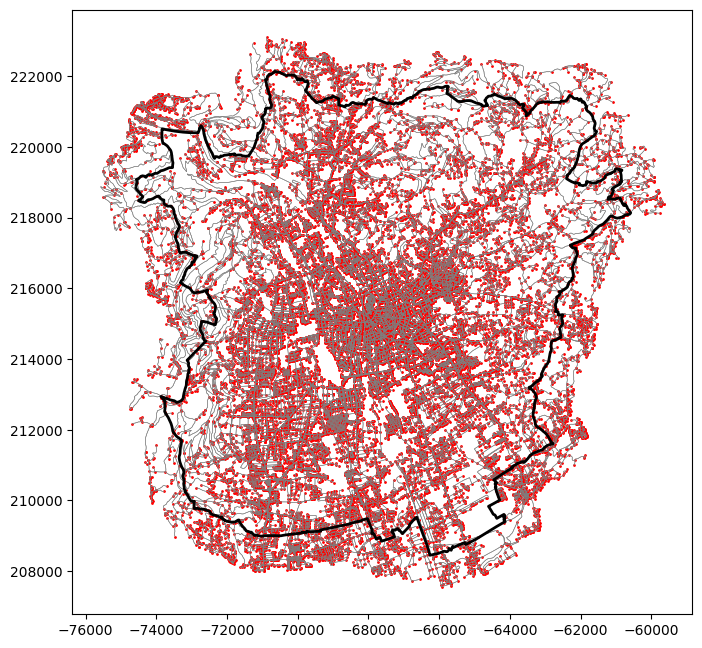

In [7]:
ax = edges.plot(figsize=(8, 8), linewidth=0.4, color="grey")
nodes.plot(ax=ax, markersize=1, color="red")

gdf_graz.boundary.plot(ax=ax, edgecolor="black", linewidth=2)

##### POIs in Graz and surrounding area withing 1000m: public transport stations, supermarkets, green spaces, pharmacies, doctors


Define POI tags (without shop=convenience and leisure=garden)

In [8]:
tags = {
    # public tranport stations & stops
    "highway": ["platform", "bus_stop"],
    "public_transport": ["platform", "stop_position"],
    "railway": ["platform", "tram_stop", "station", "halt"],

    # supermarkets
    "shop": ["supermarket", "chemist"],

    # green spaces
    "leisure": ["park"],

    # pharmacies & doctors
    "amenity": ["doctors", "hospital", "clinic", "pharmacy"],
}

Load POI

In [9]:
pois = ox.features_from_polygon(buffered_poly_wgs84, tags=tags) # osmnx sends a request to the Overpass API
pois = pois.to_crs("EPSG:31256")

Quick overview map: Plot POIs per tag and boundary of Graz

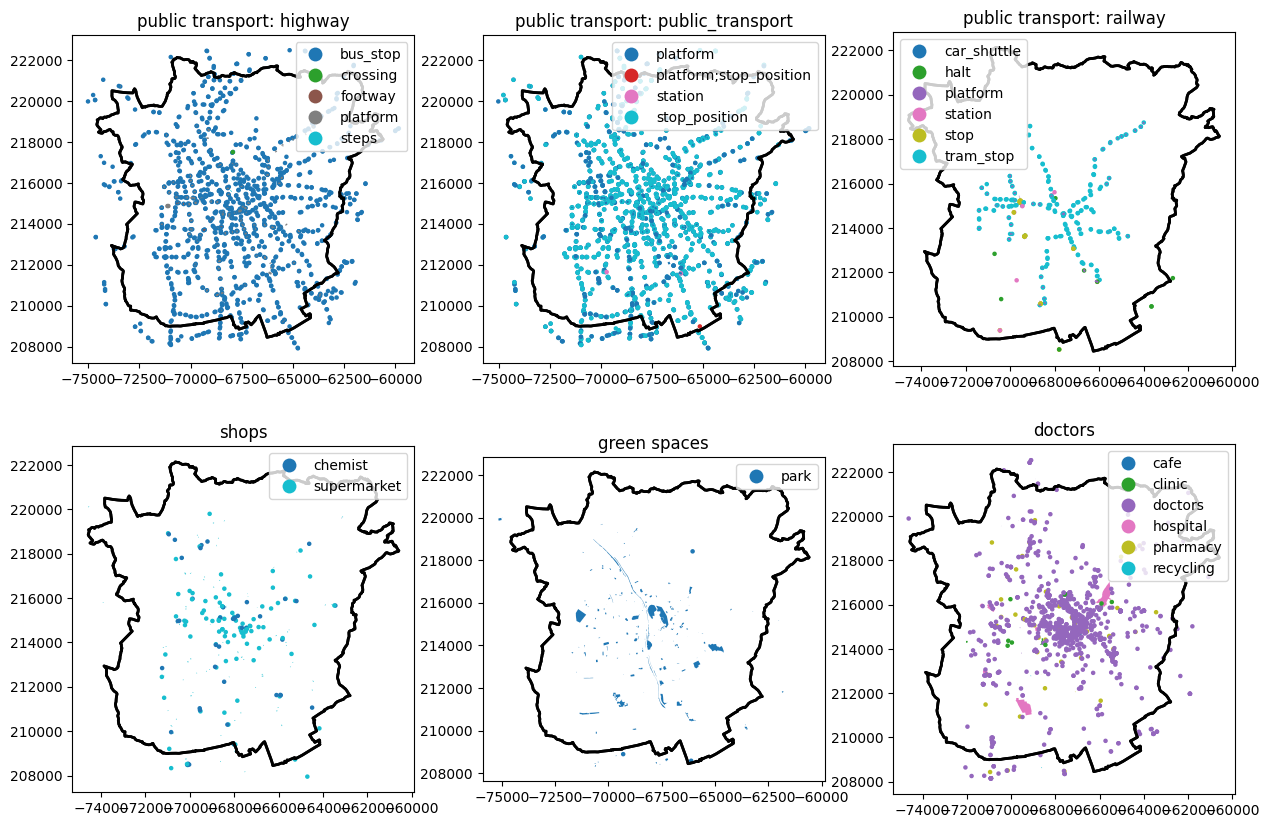

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

ax1_1 = axs[0, 0]
pois.plot(ax=ax1_1, column="highway", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_1, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_1, facecolor="none", edgecolor="black", linewidth=2)
ax1_1.set_title("public transport: highway")

ax1_2 = axs[0, 1]
pois.plot(ax=ax1_2, column="public_transport", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_2, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_2, facecolor="none", edgecolor="black", linewidth=2)
ax1_2.set_title("public transport: public_transport")

ax1_3 = axs[0, 2]
pois.plot(ax=ax1_3, column="railway", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax1_3, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax1_3, facecolor="none", edgecolor="black", linewidth=2)
ax1_3.set_title("public transport: railway")

ax2 = axs[1, 0]
pois.plot(ax=ax2, column="shop", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax2, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax2, facecolor="none", edgecolor="black", linewidth=2)
ax2.set_title("shops")

ax3 = axs[1, 1]
pois.plot(ax=ax3, column="leisure", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax3, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax3, facecolor="none", edgecolor="black", linewidth=2)
ax3.set_title("green spaces")

ax4 = axs[1, 2]
pois.plot(ax=ax4, column="amenity", legend=True, markersize=5)
gdf_graz.boundary.plot(ax=ax4, edgecolor="black", linewidth=2)
gdf_graz.plot(ax=ax4, facecolor="none", edgecolor="black", linewidth=2)
ax4.set_title("doctors")

plt.show()

Quick overview: Display number of features

In [11]:
for col in ["amenity", "shop", "leisure", "highway", "public_transport", "railway"]:
    if col in pois.columns:
        print(f"\nDistribution for {col}:")
        print(pois[col].value_counts())


Distribution for amenity:
amenity
doctors      1055
pharmacy       69
clinic         23
hospital        8
recycling       2
cafe            1
Name: count, dtype: int64

Distribution for shop:
shop
supermarket    183
chemist         45
Name: count, dtype: int64

Distribution for leisure:
leisure
park    200
Name: count, dtype: int64

Distribution for highway:
highway
bus_stop    1399
platform     279
footway       24
steps          2
crossing       1
Name: count, dtype: int64

Distribution for public_transport:
public_transport
platform                  1717
stop_position             1487
station                      8
platform;stop_position       1
Name: count, dtype: int64

Distribution for railway:
railway
tram_stop      226
platform       108
stop            28
halt            11
station          9
car_shuttle      1
Name: count, dtype: int64


##### Population of Graz (100m grid)

In [12]:
# open grid data set (population grid)
src = rasterio.open(path_pop)
print(src.crs)

# project Graz border into grid CRS (ESRI: 54009)
graz_geom = gdf_graz.to_crs(src.crs).geometry.iloc[0]

# mask grid with Graz geometry (pixels outside Graz are removed)
out_img, out_transform = mask(
    dataset=src,
    shapes=[graz_geom],
    crop=True
)

# copy metadata from the original grid and adjust metadata to the cropped grid
out_meta = src.meta.copy()
out_meta.update({
    "height": out_img.shape[1],
    "width":  out_img.shape[2],
    "transform": out_transform
})

# write and save a new grid
with rasterio.open(path_pop_graz, "w", **out_meta) as dst:
    dst.write(out_img)

ESRI:54009


Load cropped Graz population grid

In [13]:
with rasterio.open(path_pop_graz) as dataset:
    graz_pop = dataset.read(1)

Quick overview of Graz population grid

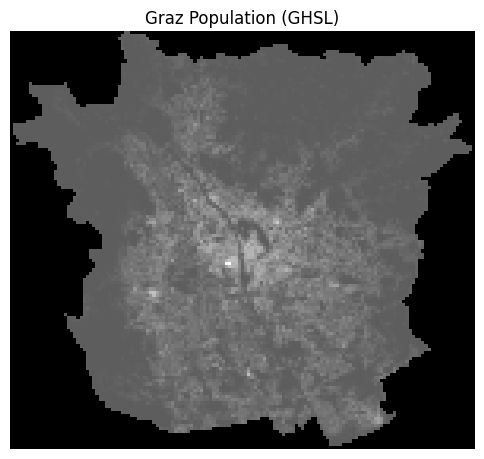

In [14]:
plt.figure(figsize=(6, 6))
plt.imshow(graz_pop, cmap="gray")
plt.title("Graz Population (GHSL)")
plt.axis("off")
plt.show()

##### Buildings of Graz

In [15]:
# load buildings of Graz
gdf_buildings = ox.features_from_place(
    place_name,
    tags={"building": True}
)
gdf_buildings = gdf_buildings.to_crs(epsg=31256)

Quick overview map: Plot buildings of Graz

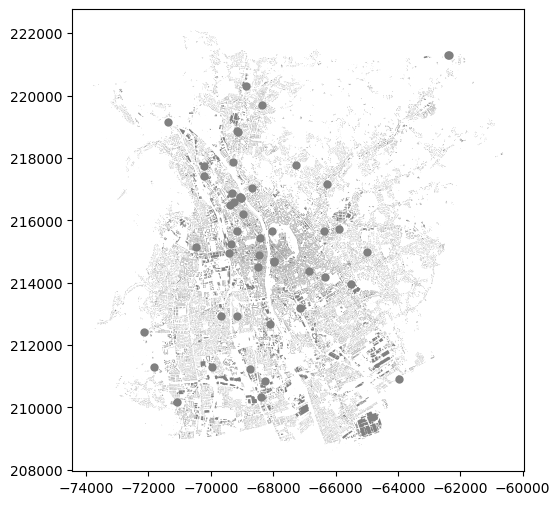

In [16]:
# all building data of Graz
fig, ax = plt.subplots(figsize=(6, 6))
gdf_buildings.plot(ax=ax, color="grey", linewidth=0)
plt.show()

##### Residential areas of Graz

In [17]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)

gdf_residential = gdf_residential.dissolve()

gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

c:\Users\korne\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 253 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


Quick overview map: Plot residential areas of Graz

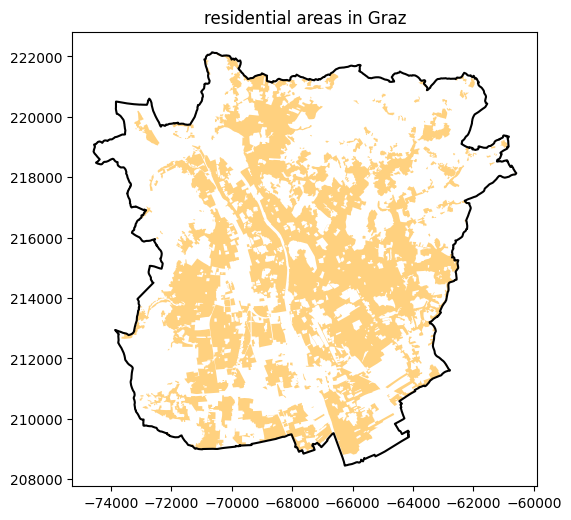

In [18]:
ax = gdf_graz.boundary.plot(edgecolor="black", figsize=(6, 6))

gdf_residential.plot(
    ax=ax,
    color="orange",
    alpha=0.5
)

plt.title("residential areas in Graz")
plt.show()